In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)
# np.random.seed(0)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=0.0, n_tapers=1)


frequency resolution = 4.0


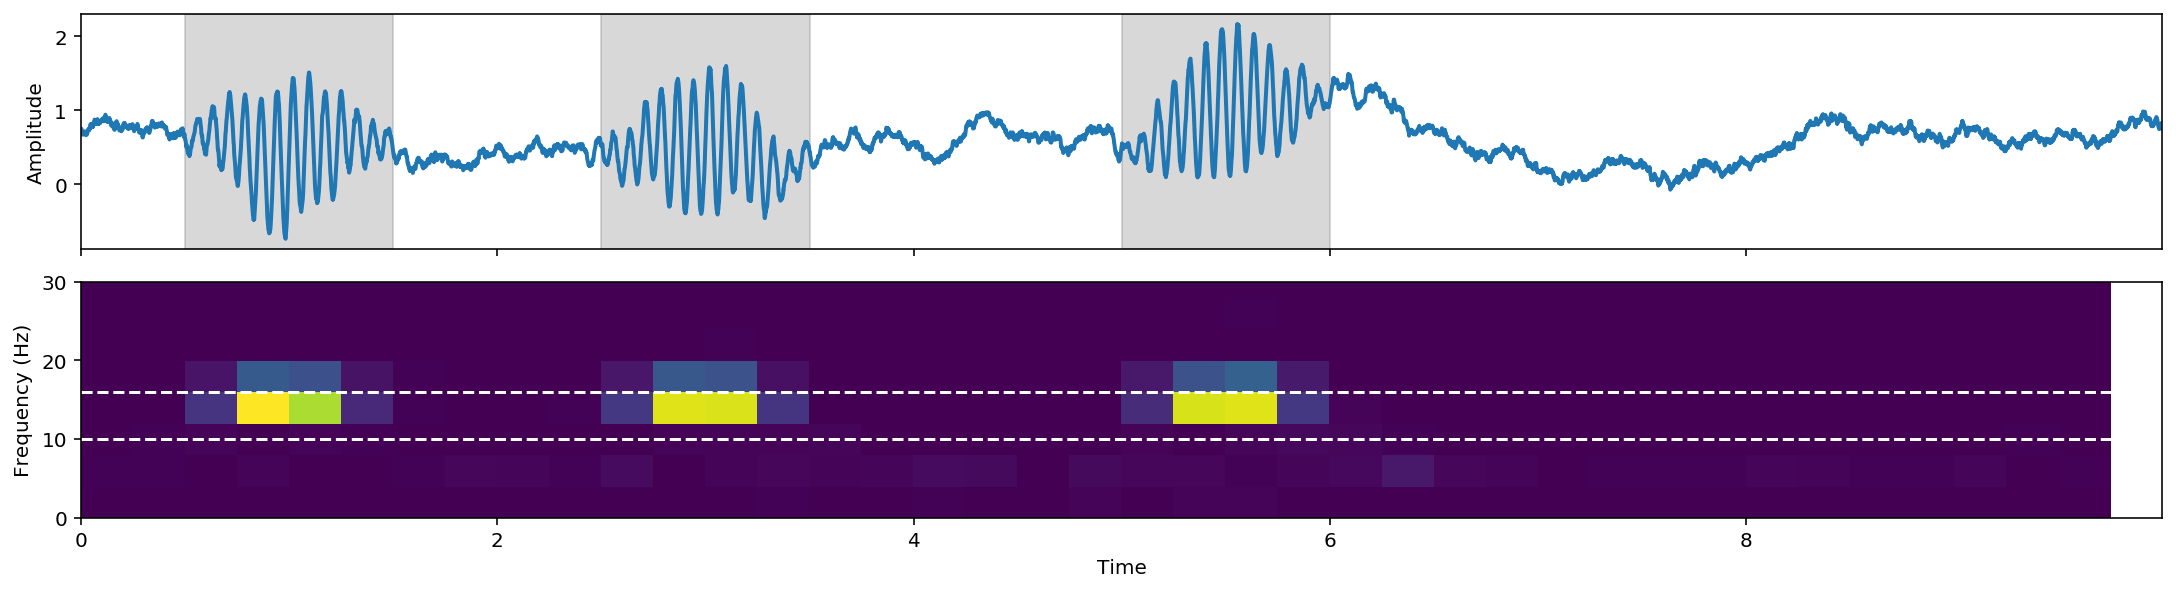

In [3]:
from spindle_detector.simulate_LFP import simulate_LFP, simulate_time
from spectral_connectivity import Multitaper, Connectivity

n_samples, sampling_frequency = 10000, 1000
time = simulate_time(n_samples, sampling_frequency)

spindle_times = np.array([0.500, 2.500, 5.000])
spindle_width = 1.000

lfp = simulate_LFP(time, spindle_times,
                   spindle_width=spindle_width, spindle_amplitude=2)

fig, axes = plt.subplots(2, 1, figsize=(15, 4), sharex=True, constrained_layout=True)
axes[0].plot(time, lfp, linewidth=2)
axes[0].set_xlim((time.min(), time.max()))
axes[0].set_ylabel('Amplitude')
for start_time in spindle_times:
    axes[0].axvspan(start_time, start_time + spindle_width,
                    alpha=0.3, color='grey', label='pause', zorder=0)
    
m = Multitaper(lfp, sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=1,
               time_window_duration=0.250,
               time_window_step=0.250,
               start_time=time.min())
c = Connectivity.from_multitaper(m)
power = c.power().squeeze()

t, f = np.meshgrid(c.time, c.frequencies)

axes[1].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time')
axes[1].set_ylim((0, 30));
axes[1].axhline(10, linestyle='--', color='white')
axes[1].axhline(16, linestyle='--', color='white')

print(f'frequency resolution = {m.frequency_resolution}')

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=0, n_tapers=1)


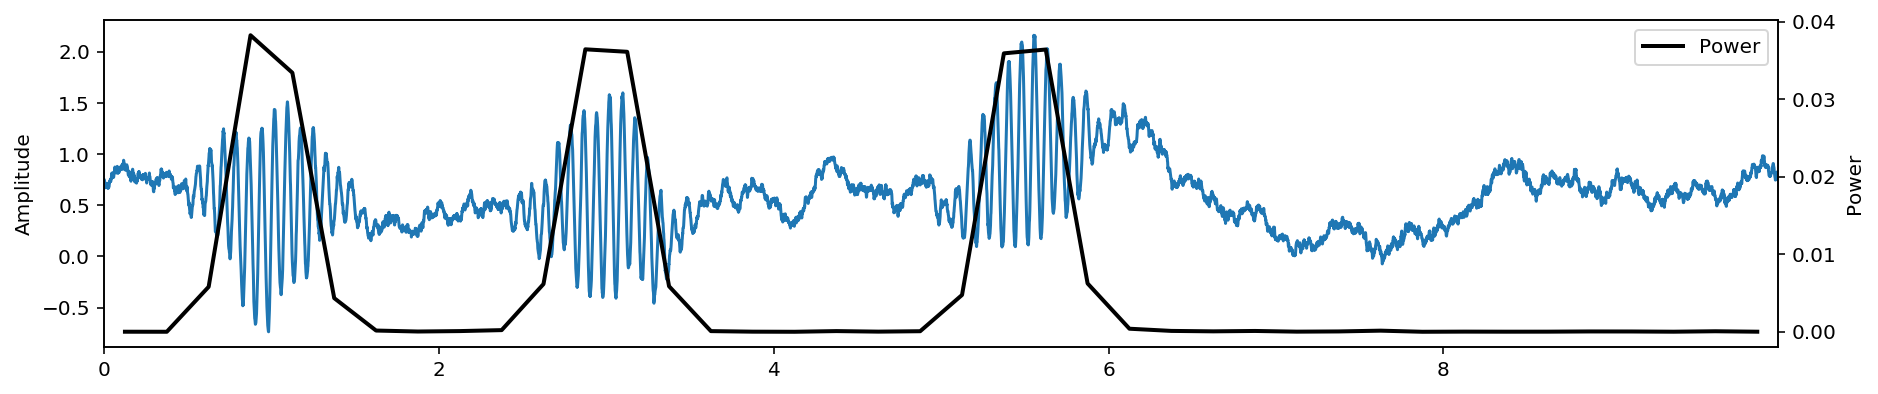

In [4]:
from spindle_detector.lfp_likelihood import estimate_spindle_band_power

plt.figure(figsize=(15, 3))
plt.plot(time, lfp, label='lfp')
plt.ylabel('Amplitude')
t, p = estimate_spindle_band_power(lfp, sampling_frequency)

twin_ax = plt.gca().twinx()
twin_ax.plot(t, p, color='black', linewidth=2, label='Power')
twin_ax.set_ylabel('Power')

plt.xlim((time.min(), time.max()));
plt.xlabel('Time')
twin_ax.legend()

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.25, time_window_step=0.25,
           detrend_type='constant', start_time=0, n_tapers=1)


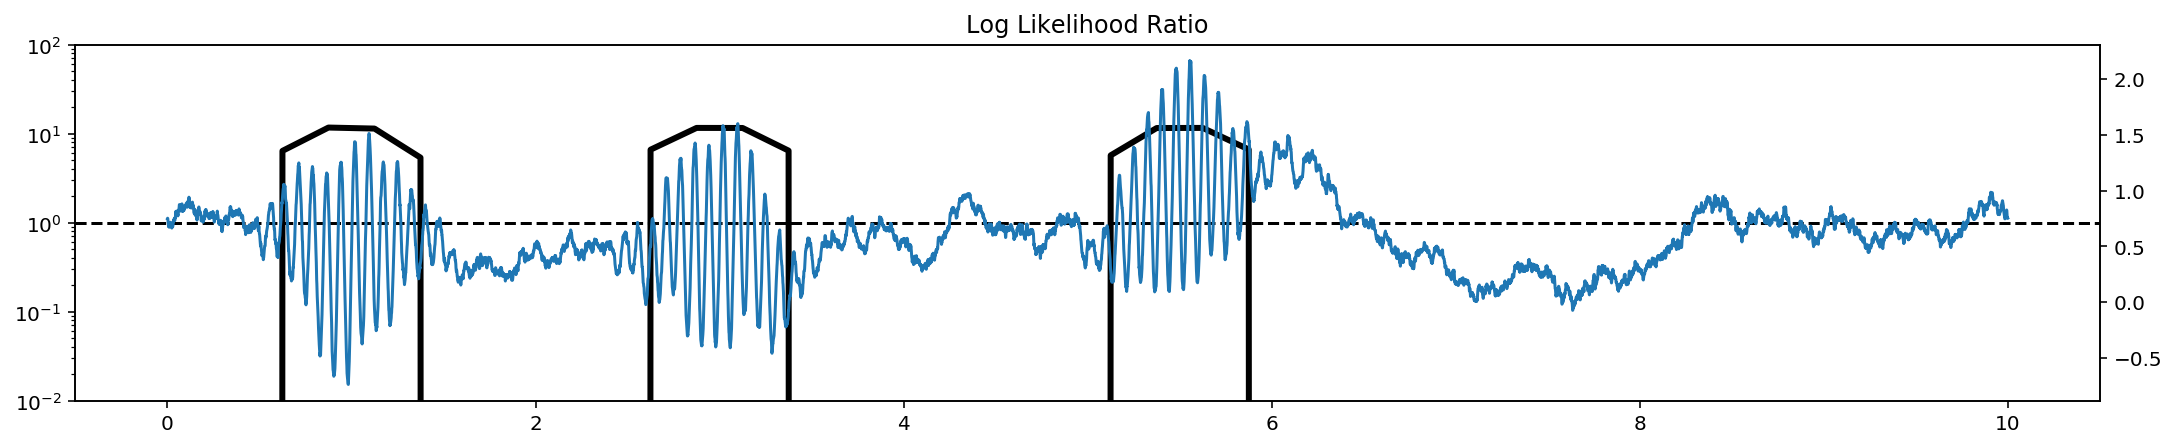

In [5]:
from spindle_detector.lfp_likelihood import fit_lfp_likelihood

t, spindle_band_power = estimate_spindle_band_power(lfp, sampling_frequency)

is_spindle = np.zeros_like(t, dtype=np.bool)

for start_time in spindle_times:
    is_spindle[(t >= start_time) & (t <= start_time + spindle_width)] = True

likelihood_func = fit_lfp_likelihood(spindle_band_power, is_spindle)

log_likelihood = likelihood_func(spindle_band_power)

fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True, constrained_layout=True)
ax.semilogy(t, log_likelihood[:, 1] - log_likelihood[:, 0], color='black', linewidth=3)
ax.set_ylim((1E-2, 1E2))
ax.axhline(1, linestyle='--', color='black')

twin_ax = ax.twinx()
twin_ax.plot(time, lfp)

plt.title('Log Likelihood Ratio');

converged = True


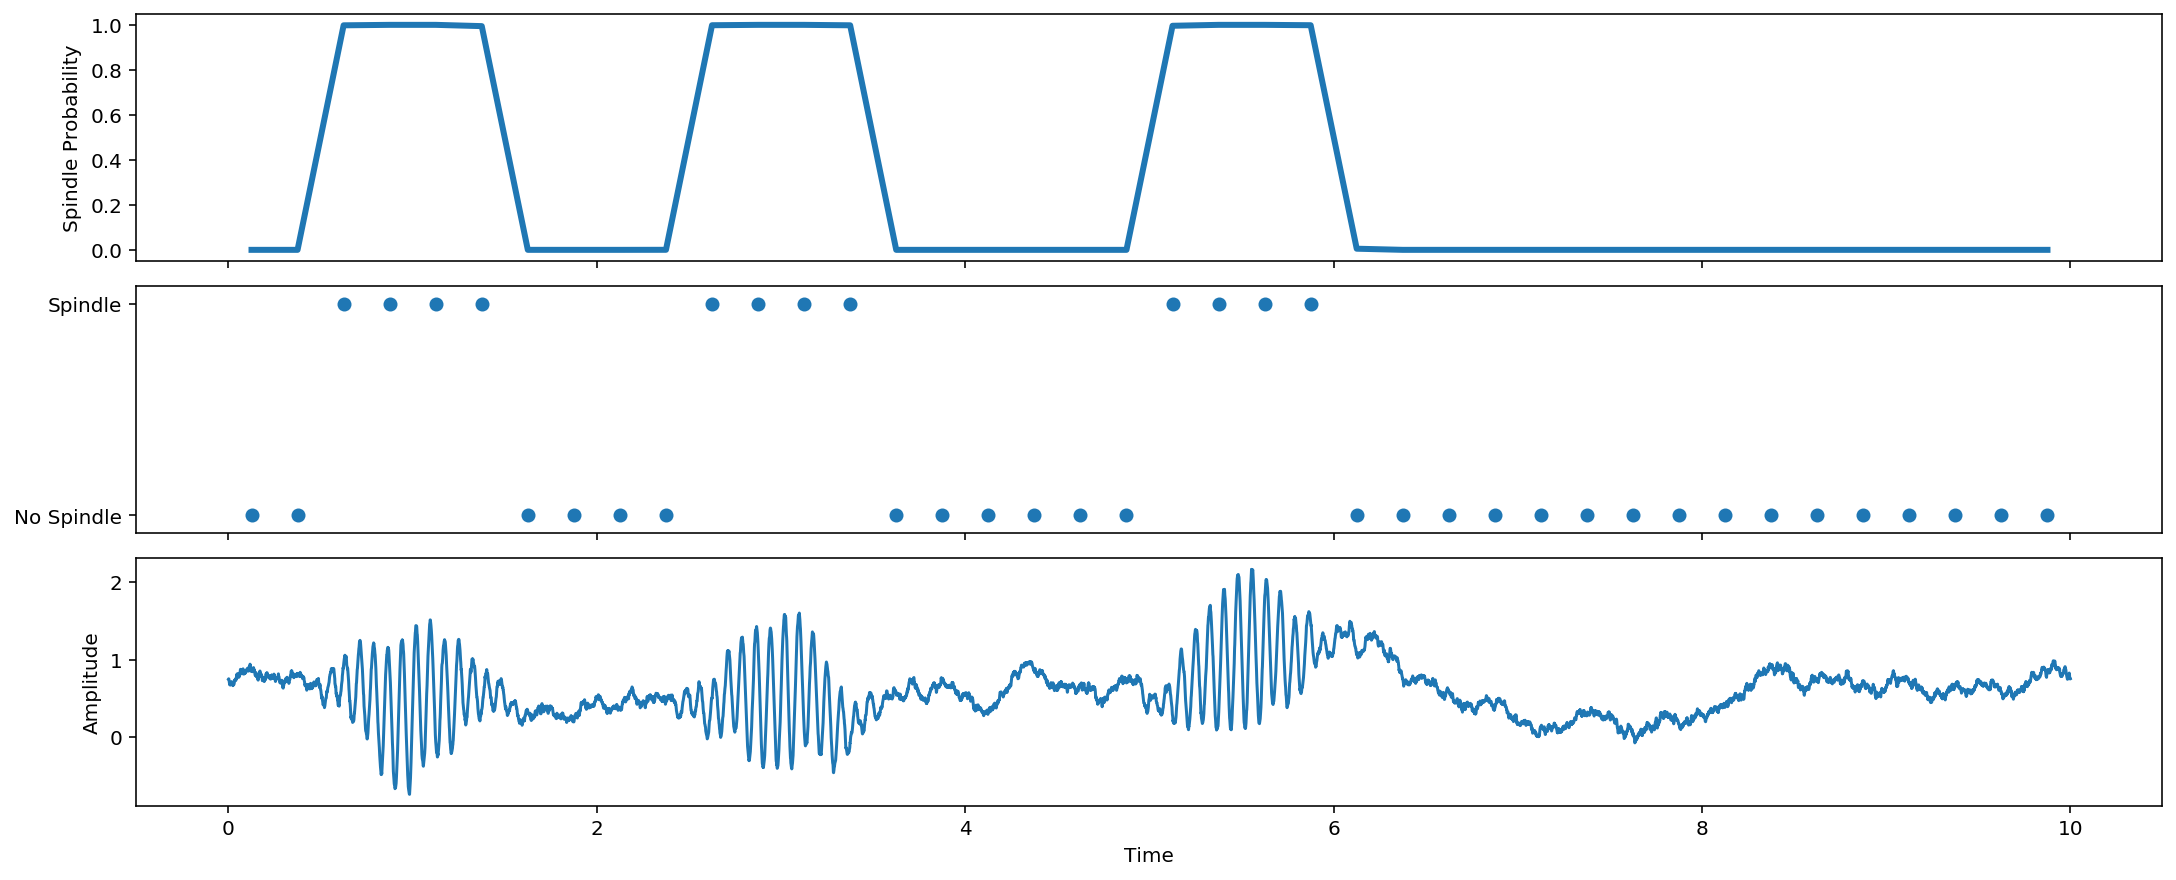

In [6]:
from hmmlearn import hmm

startprob_prior = np.log(np.array([np.spacing(1), 1.0 - np.spacing(1)]))
model = hmm.GaussianHMM(n_components=2, covariance_type="full", startprob_prior=startprob_prior, n_iter=100)
model = model.fit(np.log(spindle_band_power))
print(f'converged = {model.monitor_.converged}')

fig, axes = plt.subplots(3, 1, figsize=(15, 6), sharex=True, constrained_layout=True)

axes[0].plot(t, model.predict_proba(np.log(spindle_band_power))[:, 1], linewidth=3)
axes[0].set_ylabel('Spindle Probability')
axes[1].scatter(t, model.predict(np.log(spindle_band_power)))
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['No Spindle', 'Spindle'])
axes[2].plot(time, lfp)
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time');